# 01 – Credit Risk EDA & Training (German Credit)

Objetivo de este notebook:

1. Cargar el dataset público de German Credit desde `data/raw/`.
2. Entender la distribución de la variable objetivo (default / no default).
3. Definir el conjunto de features (numéricas y categóricas) para el modelo.
4. Entrenar dos modelos:
   - Baseline interpretable: **Logistic Regression**
   - Modelo más robusto: **RandomForest** (o XGBoost, opcional)
5. Evaluar con métricas centradas en la clase de **default**:
   - F1-score
   - Recall
   - ROC-AUC
   - Accuracy (solo referencia)
6. Generar artefactos:
   - Pipeline entrenado (`credit_pipeline.joblib`)
   - Métricas en JSON (`metrics_credit_v1.json`)
   - Datos preparados para explicabilidad con SHAP (global y local)


In [2]:
#Librerias
import os
from pathlib import Path
import json
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    f1_score,
    recall_score,
    accuracy_score,
    precision_score,
)
from sklearn.pipeline import Pipeline
import seaborn as sns


import shap
import joblib
import matplotlib.pyplot as plt

In [3]:
# === Diccionarios de mapeo para explicaciones humanas ===

FEATURE_LABELS = {
    "Status": "Estado de la cuenta corriente",
    "CreditHistory": "Historial crediticio",
    "Purpose": "Propósito del crédito",
    "Savings": "Cuenta de ahorros",
    "EmploymentDuration": "Antigüedad laboral",
    "InstallmentRate": "Porcentaje de la cuota sobre el ingreso",
    "PersonalStatusSex": "Estado civil y sexo",
    "OtherDebtors": "Otros deudores o garantes",
    "PresentResidence": "Tiempo en la residencia actual",
    "Property": "Propiedad",
    "OtherInstallmentPlans": "Otros planes de pago",
    "Housing": "Tipo de vivienda",
    "NumberExistingCredits": "Número de créditos existentes",
    "Job": "Ocupación",
    "PeopleLiable": "Personas a cargo",
    "Telephone": "Teléfono",
    "ForeignWorker": "Trabajador extranjero",
    "Duration": "Duración del crédito (meses)",
    "CreditAmount": "Monto del crédito",
    "Age": "Edad",
}

STATUS_MAP = {
    1: "Sin cuenta corriente",
    2: "Saldo < 0",
    3: "0 ≤ saldo < 200",
    4: "≥ 200 o salario por ≥ 1 año",
}

CREDIT_HISTORY_MAP = {
    0: "Retrasos en pagos en el pasado",
    1: "Cuenta crítica u otros créditos en otras instituciones",
    2: "Sin créditos previos / créditos pagados correctamente",
    3: "Créditos existentes pagados correctamente hasta ahora",
    4: "Todos los créditos en este banco pagados correctamente",
}

PURPOSE_MAP = {
    0: "Otros",
    1: "Automóvil (nuevo)",
    2: "Automóvil (usado)",
    3: "Muebles / equipamiento",
    4: "Radio / televisión",
    5: "Electrodomésticos",
    6: "Reparaciones",
    7: "Educación",
    8: "Vacaciones",
    9: "Reentrenamiento",
    10: "Negocios",
}

SAVINGS_MAP = {
    1: "Desconocido / sin ahorros",
    2: "< 100",
    3: "100 ≤ ahorro < 500",
    4: "500 ≤ ahorro < 1000",
    5: "≥ 1000",
}

EMPLOYMENT_MAP = {
    1: "Desempleado",
    2: "< 1 año",
    3: "1 a < 4 años",
    4: "4 a < 7 años",
    5: "≥ 7 años",
}

INSTALLMENT_RATE_MAP = {
    1: "≥ 35% del ingreso",
    2: "25% a < 35% del ingreso",
    3: "20% a < 25% del ingreso",
    4: "< 20% del ingreso",
}

PERSONAL_STATUS_SEX_MAP = {
    1: "Hombre: divorciado/separado",
    2: "Mujer: no soltera / Hombre: soltero",
    3: "Hombre: casado/viudo",
    4: "Mujer: soltera",
}

OTHER_DEBTORS_MAP = {
    1: "Ninguno",
    2: "Co-solicitante",
    3: "Garante",
}

PRESENT_RESIDENCE_MAP = {
    1: "< 1 año",
    2: "1 a < 4 años",
    3: "4 a < 7 años",
    4: "≥ 7 años",
}

PROPERTY_MAP = {
    1: "Desconocida / sin propiedad",
    2: "Automóvil u otra propiedad",
    3: "Ahorros vivienda / seguro de vida",
    4: "Bienes raíces",
}

OTHER_INSTALLMENT_PLANS_MAP = {
    1: "Banco",
    2: "Tiendas",
    3: "Ninguno",
}

HOUSING_MAP = {
    1: "Vivienda gratuita",
    2: "Alquiler",
    3: "Propia",
}

NUMBER_CREDITS_MAP = {
    1: "1 crédito",
    2: "2–3 créditos",
    3: "4–5 créditos",
    4: "≥ 6 créditos",
}

JOB_MAP = {
    1: "Desempleado / no calificado (no residente)",
    2: "No calificado (residente)",
    3: "Empleado calificado / funcionario",
    4: "Gerente / autónomo / altamente calificado",
}

PEOPLE_LIABLE_MAP = {
    1: "3 o más personas a cargo",
    2: "0 a 2 personas a cargo",
}

TELEPHONE_MAP = {
    1: "Sin teléfono a nombre del cliente",
    2: "Con teléfono a nombre del cliente",
}

FOREIGN_WORKER_MAP = {
    1: "Trabajador extranjero",
    2: "No es trabajador extranjero",
}

CATEGORY_VALUE_MAPS = {
    "Status": STATUS_MAP,
    "CreditHistory": CREDIT_HISTORY_MAP,
    "Purpose": PURPOSE_MAP,
    "Savings": SAVINGS_MAP,
    "EmploymentDuration": EMPLOYMENT_MAP,
    "InstallmentRate": INSTALLMENT_RATE_MAP,
    "PersonalStatusSex": PERSONAL_STATUS_SEX_MAP,
    "OtherDebtors": OTHER_DEBTORS_MAP,
    "PresentResidence": PRESENT_RESIDENCE_MAP,
    "Property": PROPERTY_MAP,
    "OtherInstallmentPlans": OTHER_INSTALLMENT_PLANS_MAP,
    "Housing": HOUSING_MAP,
    "NumberExistingCredits": NUMBER_CREDITS_MAP,
    "Job": JOB_MAP,
    "PeopleLiable": PEOPLE_LIABLE_MAP,
    "Telephone": TELEPHONE_MAP,
    "ForeignWorker": FOREIGN_WORKER_MAP,
}


In [4]:
# Configuraciones, rutas y variables globales
pd.set_option('display.max_columns', None)
plt.style.use("default")

RANDOM_STATE=42

ROOT_DIR = Path().resolve().parent
DATA_DIR = ROOT_DIR / "data" / "raw"
PROCESSED_DIR = ROOT_DIR / "data" / "processed"
MODELS_DIR = ROOT_DIR / "ml-credit" / "models"
ARTIFACTS_DIR = ROOT_DIR / "ml-credit" / "artifacts"

CSV_PATH = DATA_DIR / "german_credit_data.csv"

# Mapeo exacto basado en tu imagen anterior
rename_dict = {
    'laufkont': 'Status', 
    'laufzeit': 'Duration', 
    'moral': 'CreditHistory',
    'verw': 'Purpose', 
    'hoehe': 'CreditAmount', 
    'sparkont': 'Savings',
    'beszeit': 'EmploymentDuration', 
    'rate': 'InstallmentRate',
    'famges': 'PersonalStatusSex', 
    'buerge': 'OtherDebtors',
    'wohnzeit': 'PresentResidence', 
    'verm': 'Property', 
    'alter': 'Age',
    'weitkred': 'OtherInstallmentPlans', 
    'wohn': 'Housing',
    'bishkred': 'NumberExistingCredits', 
    'beruf': 'Job',
    'pers': 'PeopleLiable', 
    'telef': 'Telephone', 
    'gastarb': 'ForeignWorker',
    'kredit': 'CreditRisk'
}

numeric_features = [
    "Duration",      # laufzeit
    "CreditAmount",  # hoehe
    "Age"            # alter
]

categorical_features = [
    "Status",                # laufkont
    "CreditHistory",         # moral
    "Purpose",               # verw
    "Savings",               # sparkont
    "EmploymentDuration",    # beszeit
    "InstallmentRate",       # rate
    "PersonalStatusSex",     # famges
    "OtherDebtors",          # buerge
    "PresentResidence",      # wohnzeit
    "Property",              # verm
    "OtherInstallmentPlans", # weitkred
    "Housing",               # wohn
    "NumberExistingCredits", # bishkred
    "Job",                   # beruf
    "PeopleLiable",          # pers
    "Telephone",             # telef
    "ForeignWorker"          # gastarb
]

STATUS_MAP = {
    1: "Sin cuenta corriente",
    2: "Saldo negativo",
    3: "Saldo bajo",
    4: "Saldo saludable"
}

feature_cols = numeric_features + categorical_features
TARGET_COL = "CreditRisk"
TARGET_COL_MODEL = "target_default"

In [5]:
# Cargar datos
df = pd.read_csv(CSV_PATH, header=0)
df = df.rename(columns=rename_dict)

In [6]:
# Exploración inicial
df.info()
print("-" * 90)
print(df.columns)
print("-" * 90)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   Status                 1000 non-null   int64
 1   Duration               1000 non-null   int64
 2   CreditHistory          1000 non-null   int64
 3   Purpose                1000 non-null   int64
 4   CreditAmount           1000 non-null   int64
 5   Savings                1000 non-null   int64
 6   EmploymentDuration     1000 non-null   int64
 7   InstallmentRate        1000 non-null   int64
 8   PersonalStatusSex      1000 non-null   int64
 9   OtherDebtors           1000 non-null   int64
 10  PresentResidence       1000 non-null   int64
 11  Property               1000 non-null   int64
 12  Age                    1000 non-null   int64
 13  OtherInstallmentPlans  1000 non-null   int64
 14  Housing                1000 non-null   int64
 15  NumberExistingCredits  1000 non-null   

,Status,Duration,CreditHistory,Purpose,CreditAmount,Savings,EmploymentDuration,InstallmentRate,PersonalStatusSex,OtherDebtors,PresentResidence,Property,Age,OtherInstallmentPlans,Housing,NumberExistingCredits,Job,PeopleLiable,Telephone,ForeignWorker,CreditRisk
0,1,18,4,2,1049,1,2,4,2,1,4,2,21,3,1,1,3,2,1,2,1
1,1,9,4,0,2799,1,3,2,3,1,2,1,36,3,1,2,3,1,1,2,1
2,2,12,2,9,841,2,4,2,2,1,4,1,23,3,1,1,2,2,1,2,1
3,1,12,4,0,2122,1,3,3,3,1,2,1,39,3,1,2,2,1,1,1,1
4,1,12,4,0,2171,1,3,4,3,1,4,2,38,1,2,2,2,2,1,1,1


In [7]:
print(df[TARGET_COL].value_counts())
print("-" * 90)
print(df[TARGET_COL].unique())

CreditRisk
1    700
0    300
Name: count, dtype: int64
------------------------------------------------------------------------------------------
[1 0]


In [8]:
df[TARGET_COL_MODEL] = 1 - df[TARGET_COL]

# Dividir datos en entrenamiento y prueba
X = df[feature_cols].copy()
y = df[TARGET_COL_MODEL].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Shapes:")
print("X_train:", X_train.shape, "X_test:", X_test.shape)

Shapes:
X_train: (800, 20) X_test: (200, 20)


In [9]:
# Normalizacion de la columna objetivo
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ]
)

Conteo de clases:
target_default
0    560
1    240
Name: count, dtype: int64

Porcentaje de clases:
target_default
0    70.0
1    30.0
Name: proportion, dtype: float64


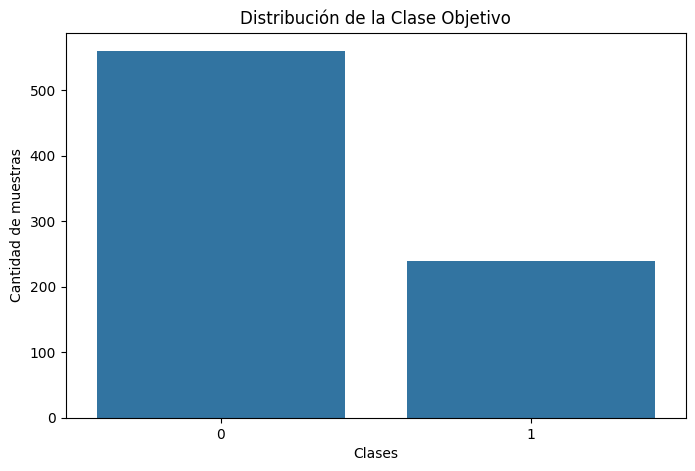

In [ ]:
print("Conteo de clases:")
print(y_train.value_counts())

print("\nPorcentaje de clases:")
print(y_train.value_counts(normalize=True) * 100)

# Grafico para identificar el desbalance
plt.figure(figsize=(8, 5))
sns.countplot(x=y_train)
plt.title('Distribución de la Clase Objetivo')
plt.xlabel('Clases')
plt.ylabel('Cantidad de muestras')
plt.show()

In [11]:
# === Modelo 1: Logistic Regression ===
model_logistic = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("classifier", LogisticRegression(
            C = 0.5,
            max_iter=1000,
            class_weight="balanced",
            random_state=RANDOM_STATE
        ))
    ]
)
model_logistic.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [12]:

# === Modelo 2: Random Forest ===
model_forest = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("classifier", RandomForestClassifier(
            n_estimators=300,
            random_state=RANDOM_STATE,
            class_weight="balanced"
        ))
    ]
)
model_forest.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [13]:
def evaluate_classifier(name, model, X_test, y_test, positive_label=1):
    """
    Evalúa un clasificador y devuelve un dict con métricas clave
    centradas en la clase positiva (default).
    """
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n=== {name} ===")
    print("Reporte de clasificación:")
    print(classification_report(y_test, y_pred, digits=4))

    f1 = f1_score(y_test, y_pred, pos_label=positive_label)
    recall = recall_score(y_test, y_pred, pos_label=positive_label)
    precision = precision_score(y_test, y_pred, pos_label=positive_label)
    roc_auc = roc_auc_score(y_test, y_proba)
    acc = accuracy_score(y_test, y_pred)

    print(f"F1 (default={positive_label}): {f1:.4f}")
    print(f"Recall (default={positive_label}): {recall:.4f}")
    print(f"Precision (default={positive_label}): {precision:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Accuracy: {acc:.4f}")

    return {
        "model": name,
        "f1_default": f1,
        "recall_default": recall,
        "precision_default": precision,
        "roc_auc": roc_auc,
        "accuracy": acc,
    }

In [ ]:
# Evaluar ambos modelos
metrics_logistic = evaluate_classifier("logistic_regression", model_logistic, X_test, y_test)
metrics_forest = evaluate_classifier("random_forest", model_forest, X_test, y_test)

# Comparacion
metrics_df = pd.DataFrame([metrics_logistic, metrics_forest])
print("\n=== Comparación de modelos ===")
display(metrics_df)

BEST_MODEL_NAME = "logistic_regression"
best_model = model_logistic



=== logistic_regression ===
Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.8250    0.7071    0.7615       140
           1     0.4875    0.6500    0.5571        60

    accuracy                         0.6900       200
   macro avg     0.6562    0.6786    0.6593       200
weighted avg     0.7238    0.6900    0.7002       200

F1 (default=1): 0.5571
Recall (default=1): 0.6500
Precision (default=1): 0.4875
ROC AUC: 0.7427
Accuracy: 0.6900

=== random_forest ===
Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.7844    0.9357    0.8534       140
           1     0.7273    0.4000    0.5161        60

    accuracy                         0.7750       200
   macro avg     0.7559    0.6679    0.6848       200
weighted avg     0.7673    0.7750    0.7522       200

F1 (default=1): 0.5161
Recall (default=1): 0.4000
Precision (default=1): 0.7273
ROC AUC: 0.7776
Accuracy: 0.7750

=== Comparación

,model,f1_default,recall_default,precision_default,roc_auc,accuracy
0,logistic_regression,0.557143,0.65,0.487500,0.742738,0.690
1,random_forest,0.516129,0.40,0.727273,0.777560,0.775


In [15]:
BEST_MODEL_NAME = "logistic_regression"
best_model = model_logistic

In [16]:
preprocessor = best_model.named_steps["preprocess"]
clf = best_model.named_steps["classifier"]

X_train_transformed = preprocessor.transform(X_train)

print("Shape de X_train original:", X_train.shape)
print("Shape de X_train transformado:", X_train_transformed.shape)

Shape de X_train original: (800, 20)
Shape de X_train transformado: (800, 71)


In [17]:
# Nombres originales numéricos
numeric_names = numeric_features
ohe = preprocessor.named_transformers_["cat"]
ohe_feature_names = ohe.get_feature_names_out(categorical_features)

feature_names_transformed = np.concatenate([numeric_names, ohe_feature_names])

print("Número de features transformadas:", len(feature_names_transformed))
print("Primeros 10 nombres de features transformadas:")
print(feature_names_transformed[:10])

Número de features transformadas: 71
Primeros 10 nombres de features transformadas:
['Duration' 'CreditAmount' 'Age' 'Status_1' 'Status_2' 'Status_3'
 'Status_4' 'CreditHistory_0' 'CreditHistory_1' 'CreditHistory_2']


In [18]:
# === SHAP – Explainer global y valores SHAP para una muestra ===
shap.initjs()

In [19]:
n_background = min(500, X_train_transformed.shape[0])
background_idx = np.random.choice(X_train_transformed.shape[0], size=n_background, replace=False)
X_background = X_train_transformed[background_idx]

print("Shape de X_background para SHAP:", X_background.shape)

Shape de X_background para SHAP: (500, 71)


In [20]:
explainer = shap.LinearExplainer(clf, X_background)
shap_values = explainer.shap_values(X_background)
print("Tipo de shap_values:", type(shap_values))

Tipo de shap_values: <class 'numpy.ndarray'>


Shape de shap_vals_array: (500, 71)


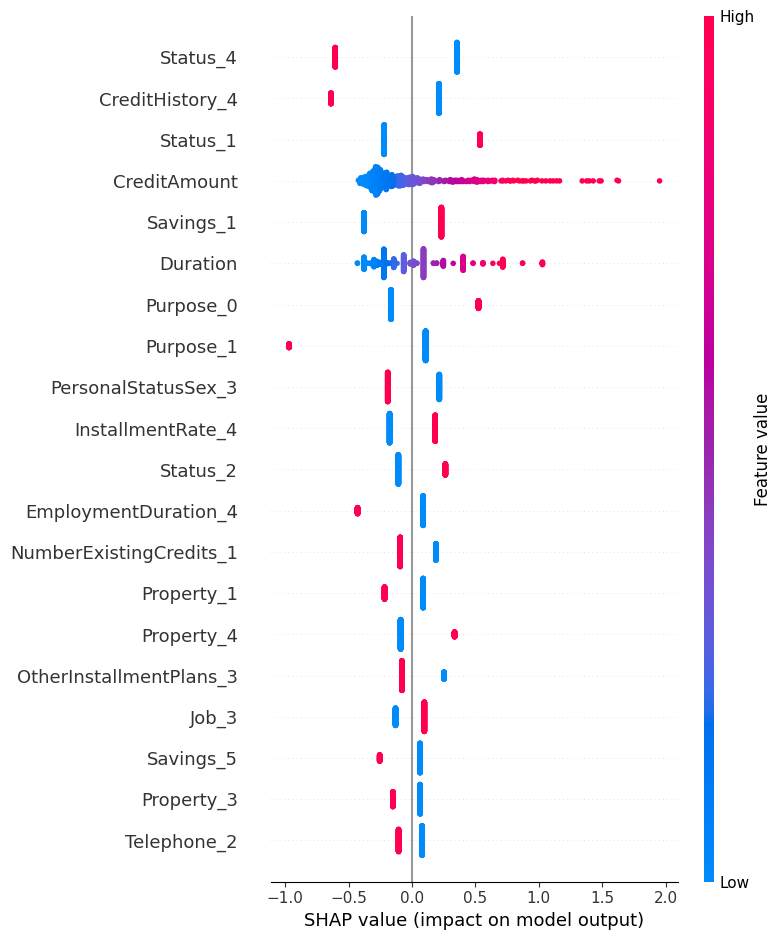

In [21]:
if isinstance(shap_values, list):
    shap_vals_array = shap_values[0]
else:
    shap_vals_array = shap_values

print("Shape de shap_vals_array:", shap_vals_array.shape)

shap.summary_plot(
    shap_vals_array,
    X_background,
    feature_names=feature_names_transformed,
    show=True
)

In [22]:
# === SHAP – Explicación LOCAL para una sola solicitud ===

def explain_single_application(
    model,
    preprocessor,
    explainer,
    X_raw_row,
    feature_names_transformed,
    top_n=5
):
    """
    Genera explicación SHAP local para una sola solicitud de crédito.
    
    Parameters
    ----------
    model : Pipeline (preprocess + classifier)
    preprocessor : ColumnTransformer
    explainer : shap explainer
    X_raw_row : DataFrame con UNA fila (features originales)
    feature_names_transformed : array de nombres post-encoding
    top_n : número de features más influyentes a devolver
    """

    X_transformed = preprocessor.transform(X_raw_row)
    prob_default = model.predict_proba(X_raw_row)[0, 1]

    shap_values = explainer.shap_values(X_transformed)

    if isinstance(shap_values, list):
        shap_vals = shap_values[0][0]
    else:
        shap_vals = shap_values[0]

    shap_df = pd.DataFrame({
        "feature": feature_names_transformed,
        "shap_value": shap_vals
    })

    shap_df["abs_impact"] = shap_df["shap_value"].abs()
    shap_df = shap_df.sort_values("abs_impact", ascending=False)

    top_features = shap_df.head(top_n).drop(columns="abs_impact")

    return prob_default, top_features


In [23]:
# Probar explicación local con una observación del test
sample_idx = 0
X_sample = X_test.iloc[[sample_idx]]

prob_default, top_features = explain_single_application(
    model=best_model,
    preprocessor=preprocessor,
    explainer=explainer,
    X_raw_row=X_sample,
    feature_names_transformed=feature_names_transformed,
    top_n=5
)

print(f"Probabilidad de default: {prob_default:.3f}")
print("Top features:")
display(top_features)


Probabilidad de default: 0.473
Top features:


,feature,shap_value
11,CreditHistory_4,-0.638564
12,Purpose_0,0.524716
6,Status_4,0.355338
32,InstallmentRate_1,-0.290389
4,Status_2,0.263265


In [ ]:
# === Función para traducir top_features ===

def build_human_explanation(X_raw_row, top_features_df, top_n=5):
    """
    Traduce las top features técnicas (One-Hot + numéricas) a
    una explicación humana basada en diccionarios.
    """

    explanations = []

    row = X_raw_row.iloc[0]

    for _, r in top_features_df.head(top_n).iterrows():
        transformed_name = r["feature"]      
        shap_val = float(r["shap_value"])
        abs_impact = abs(shap_val)

        if shap_val >= 0:
            impact_direction = "INCREASES_RISK"
            impact_text = "incrementa el riesgo de incumplimiento"
        else:
            impact_direction = "REDUCES_RISK"
            impact_text = "reduce el riesgo de incumplimiento"

        # feature numerica
        if transformed_name in ["Duration", "CreditAmount", "Age"]:
            var_name = transformed_name
            feature_label = FEATURE_LABELS.get(var_name, var_name)
            raw_value = row[var_name]

            if var_name == "Duration":
                value_label = f"{raw_value} meses de duración del crédito"
            elif var_name == "CreditAmount":
                value_label = f"Monto solicitado: {raw_value} unidades monetarias"
            elif var_name == "Age":
                value_label = f"Edad del solicitante: {raw_value} años"
            else:
                value_label = str(raw_value)

        # feature categórica One-Hot
        else:
            parts = transformed_name.split("_")
            var_name = "_".join(parts[:-1]) 
            try:
                code = int(parts[-1])
            except ValueError:
                code = None

            feature_label = FEATURE_LABELS.get(var_name, var_name)

            raw_value = row.get(var_name, None)

            value_map = CATEGORY_VALUE_MAPS.get(var_name, {})
            value_label = value_map.get(raw_value, f"Categoría {raw_value}")

        explanations.append({
            "feature": var_name,
            "feature_label": feature_label,
            "raw_value": raw_value,
            "value_label": value_label,
            "shap_value": shap_val,
            "abs_impact": abs_impact,
            "impact_direction": impact_direction,
            "impact_text": impact_text,
        })

    exp_df = pd.DataFrame(explanations)
    exp_df = exp_df.sort_values("abs_impact", ascending=False)

    return exp_df


In [ ]:
sample_idx = 0
X_sample = X_test.iloc[[sample_idx]]

prob_default, top_features = explain_single_application(
    model=best_model,
    preprocessor=preprocessor,
    explainer=explainer,
    X_raw_row=X_sample,
    feature_names_transformed=feature_names_transformed,
    top_n=5
)

print(f"Probabilidad de default: {prob_default:.3f}")

human_exp = build_human_explanation(X_sample, top_features, top_n=5)

print("\nExplicación humana:")
display(human_exp)


Probabilidad de default: 0.473

Explicación humana:


,feature,feature_label,raw_value,value_label,shap_value,abs_impact,impact_direction,impact_text
0,CreditHistory,Historial crediticio,4,Todos los créditos en este banco pagados corre...,-0.638564,0.638564,REDUCES_RISK,reduce el riesgo de incumplimiento
1,Purpose,Propósito del crédito,0,Otros,0.524716,0.524716,INCREASES_RISK,incrementa el riesgo de incumplimiento
2,Status,Estado de la cuenta corriente,2,Saldo < 0,0.355338,0.355338,INCREASES_RISK,incrementa el riesgo de incumplimiento
3,InstallmentRate,Porcentaje de la cuota sobre el ingreso,1,≥ 35% del ingreso,-0.290389,0.290389,REDUCES_RISK,reduce el riesgo de incumplimiento
4,Status,Estado de la cuenta corriente,2,Saldo < 0,0.263265,0.263265,INCREASES_RISK,incrementa el riesgo de incumplimiento


In [ ]:
# === Asignación de banda de riesgo según probabilidad ===

def assign_risk_band(prob_default: float, low: float = 0.3, high: float = 0.6) -> str:
    """
    Asigna una banda de riesgo basada en la probabilidad de default.
    
    low: umbral entre LOW y MEDIUM
    high: umbral entre MEDIUM y HIGH
    """
    if prob_default < low:
        return "LOW"
    elif prob_default < high:
        return "MEDIUM"
    else:
        return "HIGH"


In [ ]:
# === Función final: score + banda + explicación humana ===

def score_application_with_explanation(
    model,
    preprocessor,
    explainer,
    X_raw_row: pd.DataFrame,
    feature_names_transformed,
    top_n: int = 5
) -> dict:
    """
    Calcula:
      - probabilidad de default
      - banda de riesgo (LOW / MEDIUM / HIGH)
      - top features explicativas en formato listo para JSON
    """

    # Probabilidad + top features técnicas (SHAP)
    prob_default, top_features = explain_single_application(
        model=model,
        preprocessor=preprocessor,
        explainer=explainer,
        X_raw_row=X_raw_row,
        feature_names_transformed=feature_names_transformed,
        top_n=top_n
    )

    # Banda de riesgo
    risk_band = assign_risk_band(prob_default)

    # Explicación humana detallada
    human_exp_df = build_human_explanation(X_raw_row, top_features, top_n=top_n)

    top_features_payload = []
    for _, row in human_exp_df.iterrows():
        top_features_payload.append({
            "feature": row["feature"],
            "feature_label": row["feature_label"],
            "raw_value": row["raw_value"],
            "value_label": row["value_label"],
            "shap_value": row["shap_value"],
            "impact_direction": row["impact_direction"],
            "impact_text": row["impact_text"],
        })

    result = {
        "probability_default": float(prob_default),
        "risk_band": risk_band,
        "top_features": top_features_payload
    }

    return result


In [ ]:
# Probar funcion final con una muestra 
sample_idx = 0
X_sample = X_test.iloc[[sample_idx]]

result = score_application_with_explanation(
    model=best_model,
    preprocessor=preprocessor,
    explainer=explainer,
    X_raw_row=X_sample,
    feature_names_transformed=feature_names_transformed,
    top_n=5
)

import pprint
pprint.pp(result)


{'probability_default': 0.47267835029321653,
 'risk_band': 'MEDIUM',
 'top_features': [{'feature': 'CreditHistory',
                   'feature_label': 'Historial crediticio',
                   'raw_value': 4,
                   'value_label': 'Todos los créditos en este banco pagados '
                                  'correctamente',
                   'shap_value': -0.6385638506847987,
                   'impact_direction': 'REDUCES_RISK',
                   'impact_text': 'reduce el riesgo de incumplimiento'},
                  {'feature': 'Purpose',
                   'feature_label': 'Propósito del crédito',
                   'raw_value': 0,
                   'value_label': 'Otros',
                   'shap_value': 0.5247156372844336,
                   'impact_direction': 'INCREASES_RISK',
                   'impact_text': 'incrementa el riesgo de incumplimiento'},
                  {'feature': 'Status',
                   'feature_label': 'Estado de la cuenta corriente',
  

In [ ]:
# === Guardar metricas y configuración del modelo ===

metrics_payload = {
    "dataset_name": "german_credit_data",
    "target_column": "target_default",
    "positive_class": 1,
    "description_positive_class": "default / cliente que no paga",
    "models": {
        "logistic_regression": metrics_logistic,
        "random_forest": metrics_forest,
    },
    "selected_model": BEST_MODEL_NAME,
    "features": {
        "numeric": numeric_features,
        "categorical": categorical_features,
        "all_features": numeric_features + categorical_features,
    },
    "risk_band_thresholds": {
        "low": 0.3,
        "high": 0.6
    }
}

ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
metrics_path = ARTIFACTS_DIR / "metrics_credit_v1.json"

with open(metrics_path, "w", encoding="utf-8") as f:
    json.dump(metrics_payload, f, indent=2, ensure_ascii=False)

metrics_path


PosixPath('/home/harielpadillasanchez/Documentos/Empleo/Inbursa/Risk-Intelligence-Suite/ml-credit/artifacts/metrics_credit_v1.json')

In [ ]:
# === Guardar el modelo entrenado===

MODELS_DIR.mkdir(parents=True, exist_ok=True)

model_path = MODELS_DIR / "credit_pipeline_v1.joblib"
joblib.dump(best_model, model_path)

model_path


PosixPath('/home/harielpadillasanchez/Documentos/Empleo/Inbursa/Risk-Intelligence-Suite/ml-credit/models/credit_pipeline_v1.joblib')

In [32]:
from ml_credit import api, inference

print(inference.MODEL_PATH)
print(inference.METRICS_PATH)

sample = X_test.iloc[0].to_dict()
print(sample)
result = api.score_application(sample)



/home/harielpadillasanchez/Documentos/Empleo/Inbursa/Risk-Intelligence-Suite/ml-credit/models/credit_pipeline_v1.joblib
/home/harielpadillasanchez/Documentos/Empleo/Inbursa/Risk-Intelligence-Suite/ml-credit/artifacts/metrics_credit_v1.json
{'Duration': 12, 'CreditAmount': 3124, 'Age': 49, 'Status': 2, 'CreditHistory': 4, 'Purpose': 0, 'Savings': 1, 'EmploymentDuration': 2, 'InstallmentRate': 1, 'PersonalStatusSex': 3, 'OtherDebtors': 1, 'PresentResidence': 3, 'Property': 1, 'OtherInstallmentPlans': 1, 'Housing': 2, 'NumberExistingCredits': 2, 'Job': 2, 'PeopleLiable': 1, 'Telephone': 1, 'ForeignWorker': 2}


In [33]:

import pprint
pprint.pp(result)

{'probability_default': 0.47267835029321653,
 'risk_band': 'MEDIUM',
 'top_features': [{'feature': 'CreditHistory',
                   'feature_label': 'Historial crediticio',
                   'raw_value': 4,
                   'value_label': 'Todos los créditos en este banco pagados '
                                  'correctamente',
                   'shap_value': -0.8514184675797316,
                   'impact_direction': 'REDUCES_RISK',
                   'impact_text': 'reduce el riesgo de incumplimiento'},
                  {'feature': 'Purpose',
                   'feature_label': 'Propósito del crédito',
                   'raw_value': 0,
                   'value_label': 'Otros',
                   'shap_value': 0.69041531221636,
                   'impact_direction': 'INCREASES_RISK',
                   'impact_text': 'incrementa el riesgo de incumplimiento'},
                  {'feature': 'Savings',
                   'feature_label': 'Cuenta de ahorros',
               